# Practice 2 - Text Classification with CNN

## 실습2

## Dataset Load

In [ ]:
#실제 IMDB 리뷰 데이터셋은 영어로 된 문장이지만 tensorflow에 이미 정수로 바꾼 데이터가 포함되어 있다.
from tensorflow.keras.datasets import imdb
max_features = 1000 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) #imdb:영화 리뷰 정리 데이터, (긍정 부정 분류) 이 데이터셋 unique vocab 셋 중 상위 1000개 단어들만 가지고 오겠다.

In [ ]:
print(len(x_train), len(x_test), len(y_train), len(y_test))

In [ ]:
print(x_train[0]) #인덱싱 되어 있는 단어들의 list

In [ ]:
print(y_train[0])

In [ ]:
# 토큰으로 전처리 된 IMDB 데이터셋 - y는 1/0 긍정 부정
#print(len(x_train))
#print(len(x_test))

#print(x_train[0])
#print(len(x_train[0]))
#print(y_train[0]) #y는 1/0 긍정 부정 
#print()
#print(x_train[1])
#print(y_train[1])

In [ ]:
# 토큰의 길이가 문장의 길이마다 다르기 때문에 가장 긴 값이 무엇인지 체크! 가장 긴 리뷰의 토큰 수는 2494개이다.
max_len = 0
for x in x_train:
    if len(x) > max_len:
        max_len = len(x)
print(max_len)

## Padding

In [ ]:
# 토큰의 길이가 문장의 길이마다 다르기 때문에 최대 길이 값을 기준으로 이보다 짧은 값들은 0으로 패딩 처리 해준다.
# 문장의 토큰 길이가 max_len 이상인 경우 300만 이용.
#pad_sequences()함수는 기본적으로 maxlen보다 긴 시퀀스의 앞부분을 자른다. 이렇게 하는 이유는 일반적으로
#시퀀스의 뒷부분의 정보가 더 유용하리라 기대하기 때문. - 영화 리뷰 데이터를 생각해 보면 리뷰 끝에 뭔가 결정적인
#소감을 말할 가능성이 높으니까. 만약 뒷부분을잘라내고 싶다면 truncating 매개변수의 값을 'pre'(default)가 아닌
#'post'로 바꾸면됨
from tensorflow.keras.preprocessing import sequence
max_len = 300
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

In [ ]:
print(x_train[0])
#패딩 토큰은 시퀀스의 뒷부분이 아니라 앞부분에 추가됨.

In [ ]:
print(x_train.shape) #샘플개스 25000 x 토큰(timestamp) 개수 300

## Y label data One hot encoding

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
print(y_train_one_hot)

In [ ]:
print(y_train_one_hot[0])
print(y_test_one_hot[1])

## Model Build

In [ ]:
max_len

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#모델 Build
model = Sequential()

#Turns positive integers (indexes) into dense vectors of fixed size.
#맨 처음 층에는 입력되는 값을 알려 주어야 함
model.add(layers.Embedding(max_features, 128, input_shape=(max_len,))) #max_features 전체 vocab의 수. embedding 의 차원은 128차원. shape이 꼭 맞아야 한다.(padding을 한 이유)

#1D convolution layer(e.g. temporal convolution)
#filters = 32, the dimention of the output space(the number of filters in the convolution)
#kernel_size = 7, specifying the size of the convolution window.
#strides = 1(default)
#relu activation function
model.add(layers.Conv1D(32, 7, strides=1, activation='relu'))

#MaxPooling1D Layer
#'Downsamples' the input representation by taking the maximum value over 
#a spatial window of size pool_size. The window is shifted by strides.
#풀링 창의 크기는 5
model.add(layers.MaxPool1D(5))

model.add(layers.Flatten()) #feature맵이 filter마다 각각 다 따로 존재하는데 그 vector끼리 다 연결하겠다

model.add(layers.Dense(32, activation='relu')) #Fully connected Layer1
model.add(layers.Dense(2, activation='softmax')) #softmax - parameter 2는 최종적으로 2차원으로 줄여야 하기 때문 

model.summary()

## Training Setup

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

# early stopping 적용
# monitor = Quantity to be monitored. Defaults to "val_loss"
# mode = One of {"auto", "min", "max"}. In min mode, training will stop when
# the quantity monitored has stopped decreasing. In max mode it will stop when
# the quantity monitored has stopped increasing. In auto mode the direction is 
# automatically inferred from the name of the monitored quantity.(default)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# local에 저장하고 싶을 경우 이용
#checkpoint_filepath = './temp/checkpoint'
#mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

# optimizer에 필요한 옵션 적용
# loss와 평가 metric 적용
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) #SGD . Ada... RMSprop


## Training !

In [ ]:
history = model.fit(x_train, y_train_one_hot, epochs=3, batch_size=128, validation_split=0.2, callbacks=[es])

In [ ]:
# Training history plot

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## Test

In [ ]:
test_loss, test_acc = model.evaluate(x_test,y_test_one_hot)

In [ ]:
print("Loss:", test_loss)
print("Accuracy:", test_acc)

# 과제 2

## Data Load

In [ ]:
import pandas as pd
import numpy as np

with open('/kaggle/input/2024-1-nlp-2/Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

## 1. Text Preprocessing - Text to Word Index ID

In [32]:
words_list = [doc.strip().split() for doc in texts]
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


In [33]:
# total text tokens
total_words = []
for words in words_list:
    total_words.extend(words)
    
from collections import Counter
c = Counter(total_words)

# 빈도를 기준으로 상위 10000개의 단어들만 선택
max_features = 10000
common_words = [word for word, count in c.most_common(max_features)]

In [34]:
common_words[:10]

['영화', '너무', '봤', '좋', '진짜', '정말', '보고', '연기', '평점', '스토리']

In [35]:
#Dictionary Function
# 각 단어에 대해서 index 생성하기
words_dic = {word: index+3 for index, word in enumerate(common_words)}
#Write your code

# 각 index에 대해서 단어 기억하기
#Write your code
print(words_dic["영화"])
print(words_dic["너무"])

3
4


In [36]:
print(len(words_list))

165384


In [37]:
# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
# 문장의 시작 토큰을 1로, 어휘 사전에 없는 단어는 2로 설정해두었
filtered_indexed_words = []
#Write your code
for review_words in words_list:
    indexed_words = [1]
    for word in review_words:
        if word in words_dic:
            indexed_words.append(words_dic[word])
        else:
            indexed_words.append(2)
    filtered_indexed_words.append(indexed_words)

In [38]:
print(filtered_indexed_words[104]) #임의

[1, 379, 672, 1768, 1001, 5, 3, 256, 2]


## 2. Dataset Preparation for CNN models

In [39]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

#Write your code
# 2.1 X - input data 처리 (text tokens id_index to padded X) #max length ->padding
'''max_len = 0
for x in filtered_indexed_words:
    if len(x) > max_len:
        max_len = len(x)
print(max_len)''' #결과는 max_len 93이었다
#lengths = np.array([len(x) for x in filtered_indexed_words])
#print(np.mean(lengths), np.median(lengths)) #결과는 각각 12.4, 9.0이었다
#plt.hist(lengths)
#plt.show()
#그래프 그려 본 결과 대부분의 리뷰 길이는 20 이하임.
max_len = 20
input_data = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)
# 2.2 y - label data 처리 (one_hot_encoded y) #위에 있는 코드 가져다 작성하면 됨
label_data = to_categorical(labels)

In [40]:
print(input_data[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   1 206 251 123   4
 347   5]


In [41]:
print(label_data)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [42]:
from sklearn.model_selection import train_test_split
#Write your code
# 2.3 Train / Test Split
train_input, test_input, train_label, test_label = train_test_split(input_data, label_data, test_size = 0.1, random_state = 42)
print(train_input.shape, train_label.shape, test_input.shape, test_label.shape)

(148845, 20) (148845, 2) (16539, 20) (16539, 2)


## 3. Model Build & Setting

In [49]:
len(words_dic)

10000

In [139]:
#2차 실험

from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

#Write your code - model build
model.add(layers.Embedding(len(words_dic)+1, 64, input_shape=(max_len,)))
model.add(layers.Conv1D(16, 5, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 20, 64)         │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 16, 16)         │         5,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,530 (2.47 MB)

 Trainable params: 646,530 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop # you can add more optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad

#Write your code - model setting
#Early Stopping 구현
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
#optimizer & loss

model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])

## 4. Model Training

In [141]:
#Write your code - model training
history = model.fit(train_input, train_label, epochs = 10, batch_size = 64, validation_split=0.2, callbacks=[es])

Epoch 1/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6139 - loss: 0.6429 - val_accuracy: 0.8402 - val_loss: 0.3570
Epoch 2/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8634 - loss: 0.3228 - val_accuracy: 0.8606 - val_loss: 0.3188
Epoch 3/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8820 - loss: 0.2830 - val_accuracy: 0.8666 - val_loss: 0.3095
Epoch 4/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8921 - loss: 0.2599 - val_accuracy: 0.8678 - val_loss: 0.3107
Epoch 5/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8976 - loss: 0.2516 - val_accuracy: 0.8703 - val_loss: 0.3096
Epoch 5: early stopping


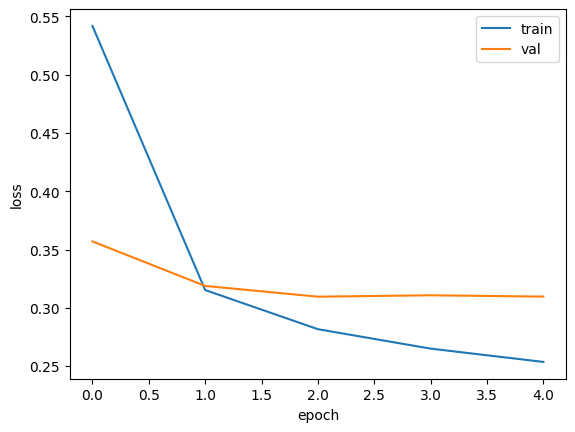

In [142]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 5. Test Model

In [143]:
test_loss, test_acc = model.evaluate(test_input,test_label)

517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8681 - loss: 0.3072


In [144]:
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Loss: 0.29857712984085083
Accuracy: 0.8716367483139038


## 6. Model Inference

In [149]:
for token in test_input[0]:
    print(token)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
5333
5842
267
111
10


In [152]:
np.array(test_input[0]).reshape(1,-1)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 5333, 5842,  267,  111,   10]],
      dtype=int32)

In [151]:
print(model.predict(np.array(test_input[0]).reshape(1,-1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
[[0.3741686 0.6258314]]


In [158]:
#Write your code - model inference #Test-set에서 하나를 뽑아서 index-->word
idx_words_dic = {index:word for word, index in words_dic.items()}
import random
for i in range(5):
    ri = random.randint(0, len(test_input)-1)
    sample = test_input[ri]
    words = list(map(lambda token: idx_words_dic.get(token) if token not in [0,1,2] else None, sample))
    words = [word for word in words if word is not None]
    print("real review: ", words)
    print("answer: ", test_label[ri])
    pred = model.predict(np.array(sample).reshape(1,-1))
    print(pred)
    if pred[0][0] > pred[0][1] and test_label[ri][0] == 1:
        print("CORRECT")
    elif pred[0][0] < pred[0][1] and test_label[ri][1] == 1:
        print("CORRECT")
    else:
        print("INCORRECT")

real review:  ['뭐', '하나', '갖춘', '없네', '재미', '교훈']
answer:  [1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.9240606  0.07593945]]
CORRECT
real review:  ['받고', '봐', '야할', '수준', '영화관', '나오면', '관객', '모두', '짜증', '내는', '영화니', '시간', '많아', '할', '일', '없', '돈', '버린', '생각하고', '보세']
answer:  [1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[9.9992347e-01 7.6506534e-05]]
CORRECT
real review:  ['기대', '별로', '재미', '없었', '거', '탄', '나오면', '봐']
answer:  [1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.9940069  0.00599306]]
CORRECT
real review:  ['평론가', '평점', '점', '이', '영화', '좋아하는', '그룹', '대', '여자', '입니', '이', '가지', '이', '영화', '모든', '것', '평가', '할', '수', '있다']
answer:  [1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.99438465 0.00561539]]
CORRECT
real review:  ['너무', '높아', '내려', '봅', '전혀', '이입', '되', '않은', '개연', '없는', '전개', '현실', '결여', '감독', '믿고', '봤', '진짜', '저', '별로', '였']
answer:  [1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[9.9945587e-01 5.4410094e-04]]
CORRECT
